# US Flights - Data Expo 2009
## by Mohamed Ramadan

## Investigation Overview

> The goal of the presenation mainly to investigate cancelled flights and reasons behind the cancellation

## Dataset Overview

> The data consists of flight arrival and departure details for all commercial flights within the USA, from October 1987 to April 2008. This is a large dataset: there are nearly 120 million records in total, and takes up 1.6 gigabytes of space compressed and 12 gigabytes when uncompressed. 
>
> As the data is huge, I decided to explore the period from 2007 to 2008. Further, I am going to work on a sample of the data to speed up the computation

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import os
import glob
import missingno  as msno
import datetime
from scipy.spatial.distance import cdist
import datetime

import warnings
warnings.simplefilter(action='ignore')

# display all columns
pd.set_option('display.max_columns', 500)

%matplotlib inline

In [3]:
# load in the dataset into a pandas dataframe
flights_sample = pd.read_csv('flights_sample_for_presentation.csv')

## Proportion of number of flights during 2007/2008

> Proportion of number of flights during 2007 is slightly higher than flights during 2008!

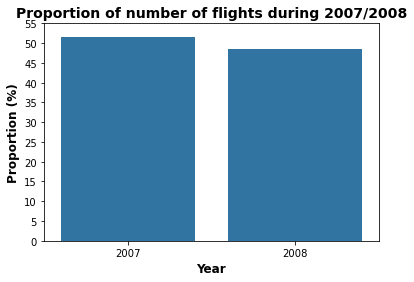

In [5]:
# define a base color (blue) to be used in the graph
base_color = sb.color_palette()[0]

# define proportion tick values and names
n_flights = flights_sample.shape[0]
max_year_prop = flights_sample.Year.value_counts().iloc[0] / n_flights
tick_props = np.arange(0, max_year_prop + 0.05, 0.05)
tick_names = ['{:0.0f}'.format(100 * v) for v in tick_props]

# plot a count plot
sb.countplot(data=flights_sample, x='Year', color=base_color)

# Change tick locations and labels
plt.yticks(tick_props * n_flights, tick_names)

# axis labels
plt.ylabel('Proportion (%)', size=12, weight='bold')
plt.xlabel('Year', size=12, weight='bold')

# figure label
plt.title('Proportion of number of flights during 2007/2008', size=14, weight='bold');

## Top Five Carriers having the highest proportion number of flights during 2007-2008

> Top five carriers are:  
> 1. Southwest Airlines Co.(WN)
> 2. American Airlines Inc.(AA)
> 3. SkyWest Airlines Inc. (OO)
> 4. Envoy Air (MQ)
> 5. US Airways Inc.(US)
>   
> Interestingly, Number of flights operated by **Southwest Airlines** is almost doubled compared to **American Airlines** which comes in the second place.

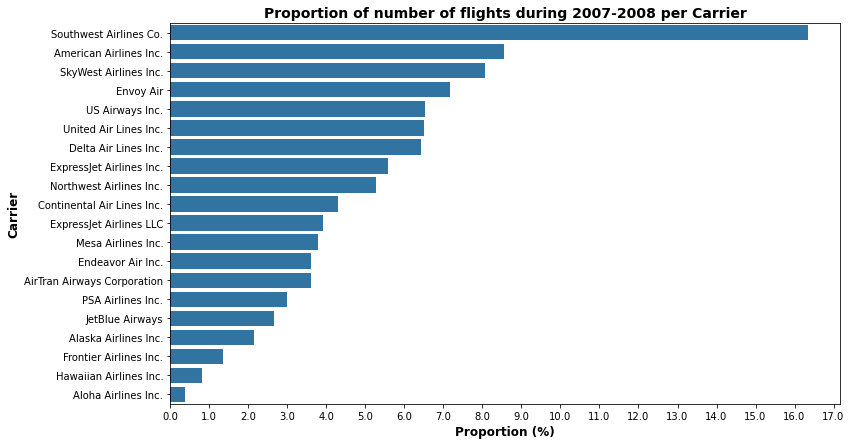

In [9]:
# define proportion tick values and names
n_flights = flights_sample.shape[0]
max_carrier_prop = flights_sample.CarrierName.value_counts().iloc[0] / n_flights
xtick_props = np.arange(0, max_carrier_prop + 0.01, 0.01)
xtick_names = ['{:0.1f}'.format(100 *v) for v in xtick_props]

# set figure size
plt.figure(figsize=(12,7))

# plot a count plot
sb.countplot(
    data=flights_sample, 
    y='CarrierName', 
    color=base_color, 
    order=flights_sample.CarrierName.value_counts().index)

# Change tick locations and labels
plt.xticks(xtick_props * n_flights, xtick_names)

# axis labels
plt.xlabel('Proportion (%)', size=12, weight='bold')
plt.ylabel('Carrier', size=12, weight='bold')

# figure label
plt.title('Proportion of number of flights during 2007-2008 per Carrier', size=14, weight='bold');

In [11]:
# fliter cancelled flights
cancelled_flights_s = flights_sample.query('Cancelled==1')

# fliter opertated (not cancelled) and non-diverted flights
flights_opt_s = flights_sample.query('(Cancelled == 0) & (Diverted == 0)')

## Investigation on Cancelled flights

### Cancelled vs Not Cancelled Flights

>97.9% of flights were not Cancelled while only 2.1% of flights were cancelled.

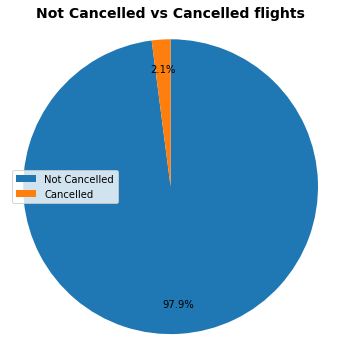

In [12]:
# calculate sorted counts
sorted_counts = flights_sample.Cancelled.value_counts()

# plot a pie chart
labels=['Not Cancelled', 'Cancelled']
plt.figure(figsize=(6,6))
plt.pie(sorted_counts,  
        startangle=90, 
        counterclock=False, 
        autopct='%1.1f%%', 
        pctdistance=0.8)
plt.axis('square')
plt.title('Not Cancelled vs Cancelled flights', size=14, weight='bold')
plt.legend(loc=6,labels=labels);


### Reasons of Cancellation

>When investigating further, we can find the most common reason for flights cancellation is Carrier 40.4% of the time followed be Weather with a percent of 39.5%

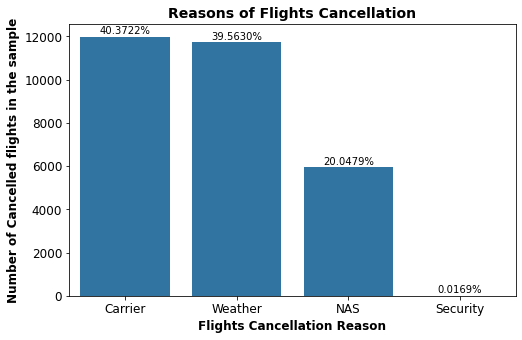

In [15]:
# set figure size
plt.figure(figsize=(8,5))

# plot a count graph
ax = sb.countplot(
        data=cancelled_flights_s, 
        x='CancellationCode', 
        color=base_color, 
        order=cancelled_flights_s.CancellationCode.value_counts().index)

# set x axis ticks and labels
plt.xticks(size=12)
plt.xlabel('Flights Cancellation Reason', size=12, weight='bold')
ax.set_xticklabels(['Carrier', 'Weather', 'NAS', 'Security'])

# set y axis tickes and labels
plt.yticks(size=12)
plt.ylabel('Number of Cancelled flights in the sample', size=12, weight='bold')

# print percentage on the bars
n_flights_cancelled = cancelled_flights_s.shape[0]

for p in ax.patches:
    percentage = f'{100 * p.get_height() / n_flights_cancelled:.4f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')

# figure title
plt.title('Reasons of Flights Cancellation', size=14, weight='bold')
plt.show();

### Flights Cancellation vs Distance of Flight
> When looking to cancellation from different prespective, we can find that the average distance of not-cancelled flights is higher (700 miles) than average distance of the cancelled flights (600 miles). The flights with more than 1000 distance is more likely to be not-cancelled.

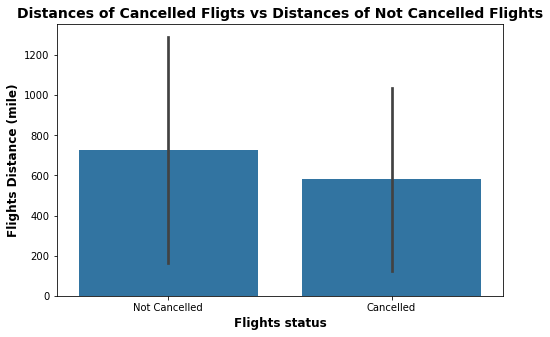

In [16]:
#figure size
plt.figure(figsize=(8,5))

# plot the mean flights distance showing the deviation around the mean for cancelled and not-cancelled flights
sb.barplot(data=flights_sample, x='Cancelled', y='Distance', color=base_color, ci='sd')

# x-axis parameters
plt.xlabel('Flights status', size=12, weight='bold')
plt.xticks([0,1], ['Not Cancelled', 'Cancelled'])

# y-axis label
plt.ylabel('Flights Distance (mile)', size=12, weight='bold')

# figure title
plt.title('Distances of Cancelled Fligts vs Distances of Not Cancelled Flights', size=14, weight='bold');

### Carrier with the most cancelling rate

>**Envoy Air** occupies the first place in the list with 4 % cancellation rate followed by **Mesa Airlines Inc.** while **Frontier Airlines Inc.** comes at the end of the list.

In [19]:
# calculate cancellation rate per Carrier
Carriers_cancel_rate = flights_sample.groupby('CarrierName')['Cancelled'].mean().reset_index()

# Sorting values in descending order
Carriers_cancel_rate.sort_values(by='Cancelled', ascending=False, ignore_index=True, inplace=True)

# rename column
Carriers_cancel_rate.rename(columns={'Cancelled': 'CancellationRate'}, inplace=True)

# convert to percent
Carriers_cancel_rate.CancellationRate = Carriers_cancel_rate.CancellationRate * 100


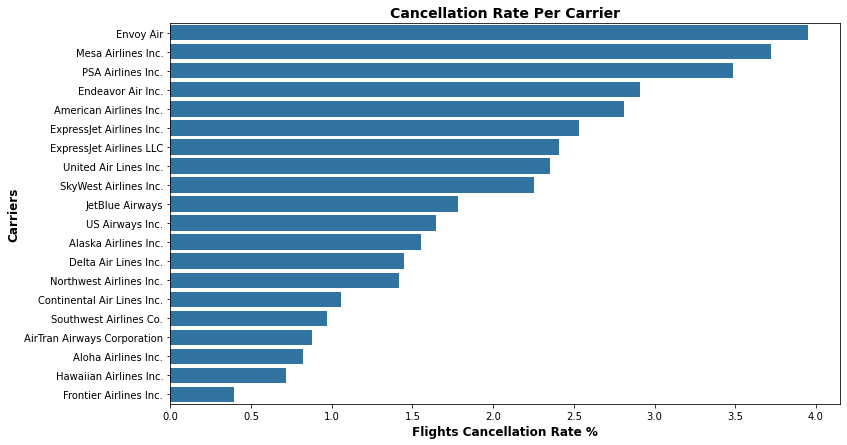

In [18]:
# set figure size
plt.figure(figsize=(12,7))

# plot a count plot
sb.barplot(
    data=Carriers_cancel_rate,
    x='CancellationRate',
    y='CarrierName', 
    color=base_color)

# x-axis parameters
plt.xlabel('Flights Cancellation Rate %', size=12, weight='bold')

# y-axis label
plt.ylabel('Carriers', size=12, weight='bold')

# figure title
plt.title('Cancellation Rate Per Carrier', size=14, weight='bold');

### Why in specific **Envoy Air** and **Mesa Airlines Inc.** are having the highest cancellation rate?

> The upcoming slide will answer this question but I am going to spoil the surprise
>The common reason of cancelling **Envoy Air** flights found to be **Weather** and not **Carrier** as I was expected. **American Airlines Inc.** comes after **Envoy Air** with the number of cancelled flights due to weather.  
While, **Mesa Airlines Inc.** cancelled flights was mainly beacuse of the **Carrier** itself.

In [20]:
# Use group_by() and size() to get the number of flights and each combination of the two variable levels as a pandas Series
cc_counts = cancelled_flights_s.groupby(['CarrierName', 'CancellationCode']).size().reset_index(name='count')

In [21]:
# Use DataFrame.pivot() to rearrange the data, to have Carriers on rows
cc_counts = cc_counts.pivot(index = 'CarrierName', columns = 'CancellationCode', values = 'count')

# rename cancellation code columns to cancellation definition
cc_counts = cc_counts.rename(columns={'A':'Carrier', 'B':'Weather', 'C':'NAS', 'D':'Security'})

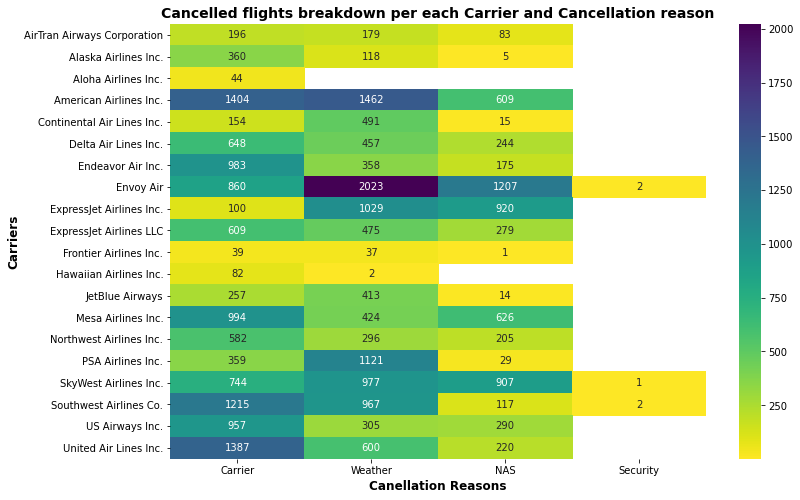

In [22]:
# plot a heat map showing Carriers vs reasons of flights cancellation
# figure size
plt.figure(figsize=(12,8))
sb.heatmap(cc_counts, annot = True, fmt = '.0f', cmap='viridis_r')

# x-axis label
plt.xlabel('Canellation Reasons', size=12, weight='bold')

# y-axis label
plt.ylabel('Carriers', size=12, weight='bold')

# figure title
plt.title('Cancelled flights breakdown per each Carrier and Cancellation reason', size=14, weight='bold');

### Want to learn more?!

It is obvious from upcoming slide that the highest number of cancelled flights of Envoy Airlines & American Airlines is correlated with flights destined to **DFW (Dallas/Fort Worth International)** and **ORD (O'Hare International Airport)**.

In [23]:
# filter cancelled flights due to Weather
cancelled_flights_s_weather = cancelled_flights_s.query('CancellationCode == "B"')

# Use group_by() and size() to get the number of flights and each combination of the two variable levels as a pandas Series
co_counts = cancelled_flights_s_weather.groupby(['CarrierName', 'Dest']).size().reset_index(name='count')

# Use DataFrame.pivot() to rearrange the data, to have Carriers on rows
co_counts = co_counts.pivot(index = 'CarrierName', columns = 'Dest', values = 'count')

# In this cell, I will apply a filter to reduce the number of columns (Destinations) for better view
# tune a thershold that minimize the number of columns and give enough informative graph
thershold = 40 # maximum number of cancelled flights in a specific Destination is less than 40
for col in co_counts.columns:
    if co_counts[col].max() < thershold:
        co_counts.drop(columns=col, inplace=True)

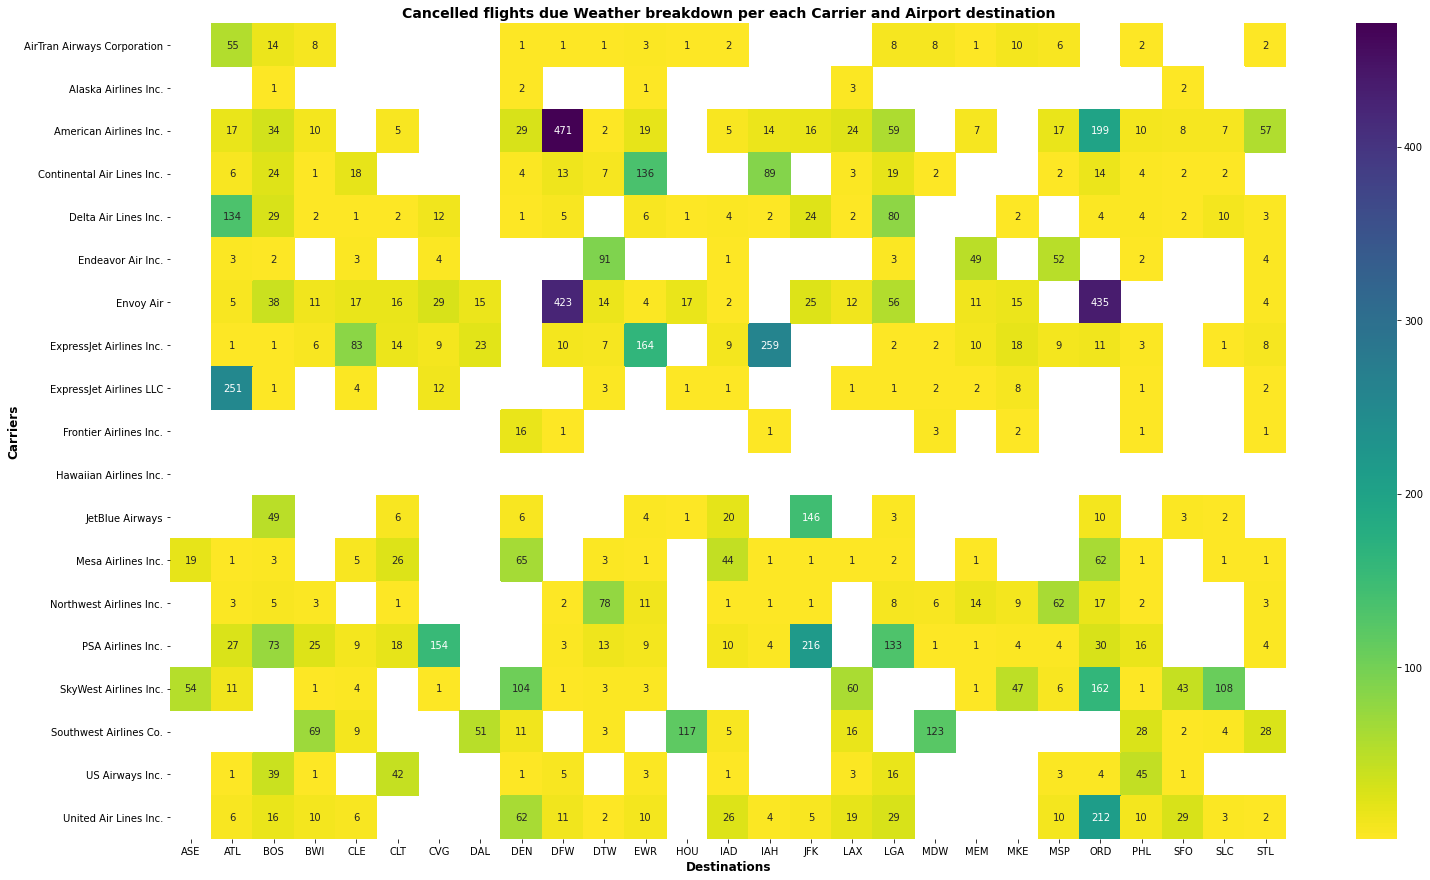

In [24]:
# plot a heat map for carriers vs Airport destinations for cancelled flights due to Weather
# figure size
plt.figure(figsize=(25,15))
sb.heatmap(co_counts, annot = True, fmt = '.0f', cmap='viridis_r')

# x-axis label
plt.xlabel('Destinations', size=12, weight='bold')

# y-axis label
plt.ylabel('Carriers', size=12, weight='bold')

# figure title
plt.title('Cancelled flights due Weather breakdown per each Carrier and Airport destination', size=14, weight='bold');

### Is it correlated with the Month of year?

> Yes, it is somehow and as expected correlated with the Month of Year. During Winter season (December-March), we can see higher number of cancelled flights for Envoy Air and Amreican Airlines (destined DFW or ORD).

In [25]:
# filter cancelled flights destined to DFW or ORD
dfw_ord_canc = cancelled_flights_s_weather.query('Dest == "DFW" | Dest =="ORD"')

# groupby Month and Carrier
dfw_ord_canc = dfw_ord_canc.groupby(['Year','Month', 'CarrierName']).size().reset_index(name='count')

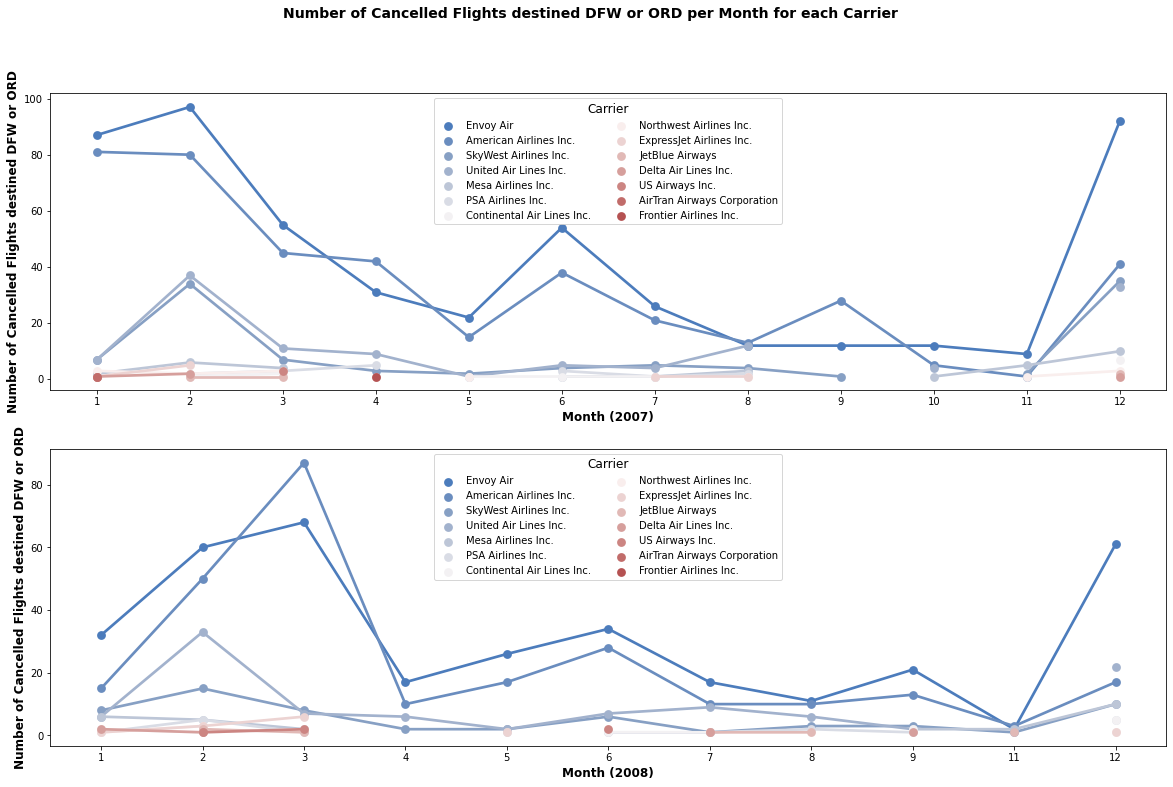

In [26]:
# plot a point plot showing counts of cancelled flights per Month for each Carrier 
plt.figure(figsize=(20,12))

# 2007
plt.subplot(2,1,1)
sb.pointplot(data=dfw_ord_canc.query('Year == 2007'), 
             x='Month', 
             y='count', 
             hue='CarrierName', 
             palette='vlag', 
             hue_order=dfw_ord_canc.CarrierName.value_counts().index)

# x-axis label
plt.xlabel('Month (2007)', size=12, weight='bold')

# y-axis label
plt.ylabel('Number of Cancelled Flights destined DFW or ORD', size=12, weight='bold')

# legend
plt.legend(loc=0, ncol=2, title='Carrier',title_fontsize=12, fontsize=10);

# 2008
plt.subplot(2,1,2)
sb.pointplot(data=dfw_ord_canc.query('Year == 2008'), 
             x='Month', 
             y='count', 
             hue='CarrierName', 
             palette='vlag', 
             hue_order=dfw_ord_canc.CarrierName.value_counts().index)

# x-axis label
plt.xlabel('Month (2008)', size=12, weight='bold')

# y-axis label
plt.ylabel('Number of Cancelled Flights destined DFW or ORD', size=12, weight='bold')

# legend
plt.legend(loc=0, ncol=2, title='Carrier',title_fontsize=12, fontsize=10);


# figure title
plt.suptitle('Number of Cancelled Flights destined DFW or ORD per Month for each Carrier', size=14, weight='bold');



## The distribution of Flights Distances

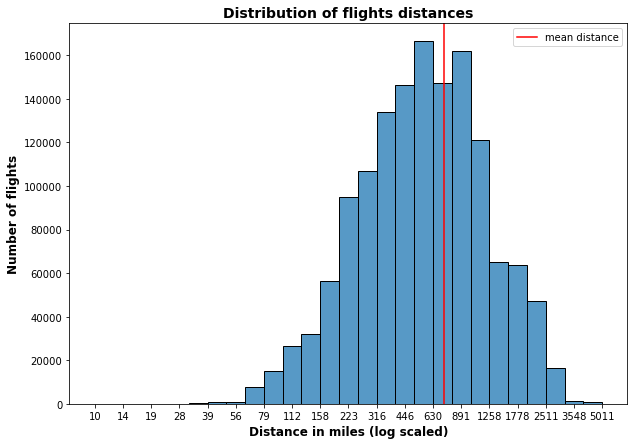

In [27]:
# x-axis log transformation funciton
def log_trans(x, inverse = False):
    """ transformation helper function """
    if not inverse:
        return np.log10(x)
    else:
        return 10 ** x

# create figure
plt.figure(figsize=(10,7))

# Bin resizing, to transform the x-axis
bins = np.arange(1,log_trans(flights_opt_s['Distance'].max())+0.1, 0.1)

# Plot the scaled data
sb.histplot(flights_opt_s['Distance'].apply(log_trans),color=base_color,bins=bins)

# Identify the tick-locations
tick_locs = np.arange(1, log_trans(flights_opt_s['Distance'].max())+0.15, 0.15)

# Apply x-ticks
plt.xticks(tick_locs, log_trans(tick_locs, inverse = True).astype(int))


# Draw mean line
plt.axvline(x=log_trans(flights_opt_s.Distance.mean()), color='r', label='mean distance')

# axis lables
plt.xlabel('Distance in miles (log scaled)', weight='bold', size=12)
plt.ylabel('Number of flights', weight='bold', size=12)

# print title
plt.title('Distribution of flights distances', weight='bold', size=14)

# show legend
plt.legend();